#Importing what we need

In [1]:
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import mnist
from matplotlib import pyplot
(trainX, trainy), (testX, testy) = mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


#Checking and reading some samples

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


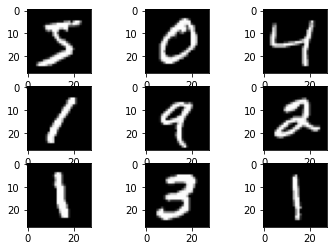

In [2]:
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()
(trainX, trainY), (testX, testY) = mnist.load_data()

#Reshaping dataset

In [3]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

#One-hot encoding

In [4]:
# one hot encoding
from tensorflow.keras.utils import to_categorical
trainY = to_categorical(trainY)
testY = to_categorical(testY)

#Normalizing and changing pixel range from [0:255] to [0:1]

In [5]:
testX = testX.astype('float32')
trainX= trainX.astype('float32')
testX = testX/255.0
trainX = trainX/255.0


# Functions used in tutorial



In [6]:
#he used those in the tutorial so i'll just put them here
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
#I already did converted integers in the last cell and normalized them

#Simple model

In [7]:
# define cnn model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop,Adam,SGD
from keras.models import Sequential
def simplemodel():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [8]:
# evaluate a model using k-fold cross-validation
from sklearn.model_selection import KFold

def modelevaluate(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = simplemodel()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)

	diagnostics(histories), sumperformance(scores)
  

  

In [9]:
# plot diagnostic learning curves
def diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()

In [10]:
# summarize model performance
def sumperformance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

In [11]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = modelevaluate(trainX, trainY)
	# learning curves
	diagnostics(histories)
	# summarize estimated performance
	sumperformance(scores)

In [12]:
trainX.max()

1.0

In [13]:
trainX.min()

0.0

> 97.100
> 97.200
> 97.700
> 97.750
> 97.300


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


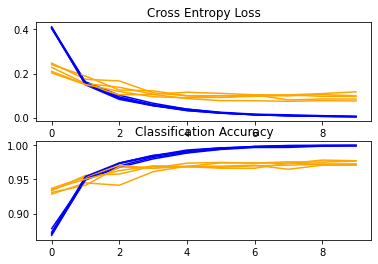

Accuracy: mean=97.410 std=0.265, n=5


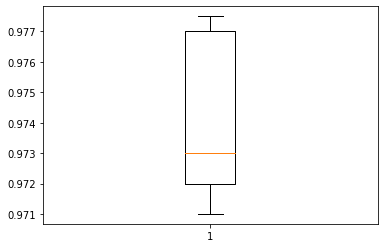

In [14]:
firstmodel = simplemodel()
modelevaluate(testX,testY)
#yes i could have used run_test_harness()


#Improved model

## Model 2: Using Batch Normalization

In [15]:
def batchmodel():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [24]:
model_2=batchmodel()

In [25]:
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               540900    
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

In [26]:
scores_2 = []
kfold = KFold(5, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in kfold.split(trainX):
    history = model_2.fit(trainX, trainY, epochs=5, batch_size=32, validation_data=(testX, testY), verbose=0)
    _, acc = model_2.evaluate(testX, testY, verbose=1)
    print('> %.3f' % (acc * 100.0))
    scores_2.append(acc)


313/313 [==============================] - 1s 2ms/step - loss: 0.0431 - accuracy: 0.9865
> 98.650
313/313 [==============================] - 1s 2ms/step - loss: 0.0389 - accuracy: 0.9887
> 98.870
313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - accuracy: 0.9879
> 98.790
313/313 [==============================] - 1s 2ms/step - loss: 0.0417 - accuracy: 0.9882
> 98.820
313/313 [==============================] - 1s 2ms/step - loss: 0.0470 - accuracy: 0.9887
> 98.870


In [27]:
print('accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores_2)*100, np.std(scores_2)*100, len(scores_2)))


accuracy: mean=98.800 std=0.081, n=5


Model 3: Increasing the depth with VGG-like pattern

We can increase the depth of the feature extractor part of the model, following a VGG-like pattern of adding more convolutional and pooling layers with the same sized filter, while increasing the number of filters. In this case, we will add a double convolutional layer with 64 filters each, followed by another max pooling layer.

In [45]:
def modelvgg():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [46]:
model_3 = modelvgg()

In [47]:
model_3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)              

In [48]:
score_3 = []
# prepare cross validation
kfold = KFold(5, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in kfold.split(trainX):
    # define model
    # fit model
    history = model_3.fit(trainX, trainY, epochs=3, batch_size=128, validation_data=(testX, testY), verbose=1)
    # evaluate model
    _, acc = model_3.evaluate(testX, testY, verbose=1)
    print('> %.3f' % (acc * 100.0))
    score_3.append(acc)


Epoch 1/3
469/469 [==============================] - 3s 6ms/step - loss: 0.5023 - accuracy: 0.8382 - val_loss: 0.0620 - val_accuracy: 0.9806
Epoch 2/3
469/469 [==============================] - 2s 5ms/step - loss: 0.0659 - accuracy: 0.9801 - val_loss: 0.0428 - val_accuracy: 0.9854
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0430 - accuracy: 0.9843
> 98.430
Epoch 1/3
469/469 [==============================] - 2s 5ms/step - loss: 0.0345 - accuracy: 0.9893 - val_loss: 0.0332 - val_accuracy: 0.9891
Epoch 2/3
469/469 [==============================] - 2s 5ms/step - loss: 0.0279 - accuracy: 0.9914 - val_loss: 0.0309 - val_accuracy: 0.9893
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0306 - accuracy: 0.9892
> 98.920
Epoch 1/3
469/469 [==============================] - 3s 5ms/step - loss: 0.0203 - accuracy: 0.9939 - val_loss: 0.0372 - val_accuracy: 0.9869
Epoch 2/3
469/469 [==============================] - 3s 5ms/step - loss: 0.0173

In [49]:
print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(score_3)*100, np.std(score_3)*100, len(score_3)))

Accuracy: mean=98.934 std=0.263, n=5
